In [8]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [17]:
df = pd.read_csv("../train.csv", index_col=0)
df_independent = df.iloc[:, :-1]

In [4]:
def calculate_vif(features: list, data: pd.DataFrame):
    """calculate VIF value for the features given on the data"""
    vif = {}
    for feature in features:
        vif[feature] = float("{:.2f}".format(variance_inflation_factor(data, data.columns.get_loc(feature))))
    return vif


def get_corr(data: pd.DataFrame):
    # Print correlation heatmap
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    f, ax = plt.subplots(figsize=(37,37))
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=True)
    
def get_vifs(data: pd.DataFrame):    
    # Get VIF and return it as a series
    numerical_cols = [feature for feature in data.columns if data[feature].dtype !='O']
    categorical_cols = [feature for feature in data.columns if data[feature].dtype == 'O']

    vif_feat = calculate_vif(numerical_cols, data[numerical_cols].dropna(axis=0))
    vif_series = pd.Series(data=vif_feat)
    return vif_series

# EDA
First we will focus in numerical variables. Importantly, 'MSSubClass' is numerical but categorical, as is "OverallQual" and 'OverallCond.' The latter two are at least ordinal (ranked 1-10), so there is a structure to the values. MSSubClass is a simple integer representing a classification, and so should be treated as such. These integers should be converted to strings. 

Let's start by investigating the numerical columns. Looking at the pairwise correlation between different columns, as well as the correlation between columns and the target, SalePrice, can help us eliminate some variables to avoid multicollinearity and reduce the number of variables we need to learn on.

In [ ]:
get_corr(df_independent)

Leaving aside the SalePrice for now, there are strong correlations between GarageArea and GarageCars, as well as GarageYrBlt and YearBuilt. TotRmsAbvGr and GrLivArea also show strong correlation, as do 1stFlrSF and TotalBsmtSF. Let's dig into those correlations a little more closely

In [ ]:
print(get_vifs(df_independent))


## YearBuilt vs YearRemodAdd
These two columns have a lot of identical values since YearRemodAdd will just contain YearBuilt if the home was never remodeled. Similarly, many garages are built with the house, so those dates are duplicated. Additional binary columns could be added to indicate that an addition/remodel was done, or a garage was built after initial construction.

## Garage

The Garage size (cars and Area) variables are also closely correlated. We will want to choose one or the other when we get to data wrangling

## Area/Room counts
The variables tracking the area of different rooms and the number of rooms are also highly correlated. This is likely because all floors have similar footprints, so the square footage won't differ much, and more room usually means more SqFt. Given the number of different variables that are correlated, keeping them all introduces lots of multicollinearity. We will want to choose only a subset of these variables.

In [ ]:
area_and_room_vars = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', "SalePrice"]
get_corr(df[area_and_room_vars])

# Electrical

Moving away from numerical variables, I'm interested in the 'Electrical' column. Particularly because I predict it will be highly correlated to the build date.

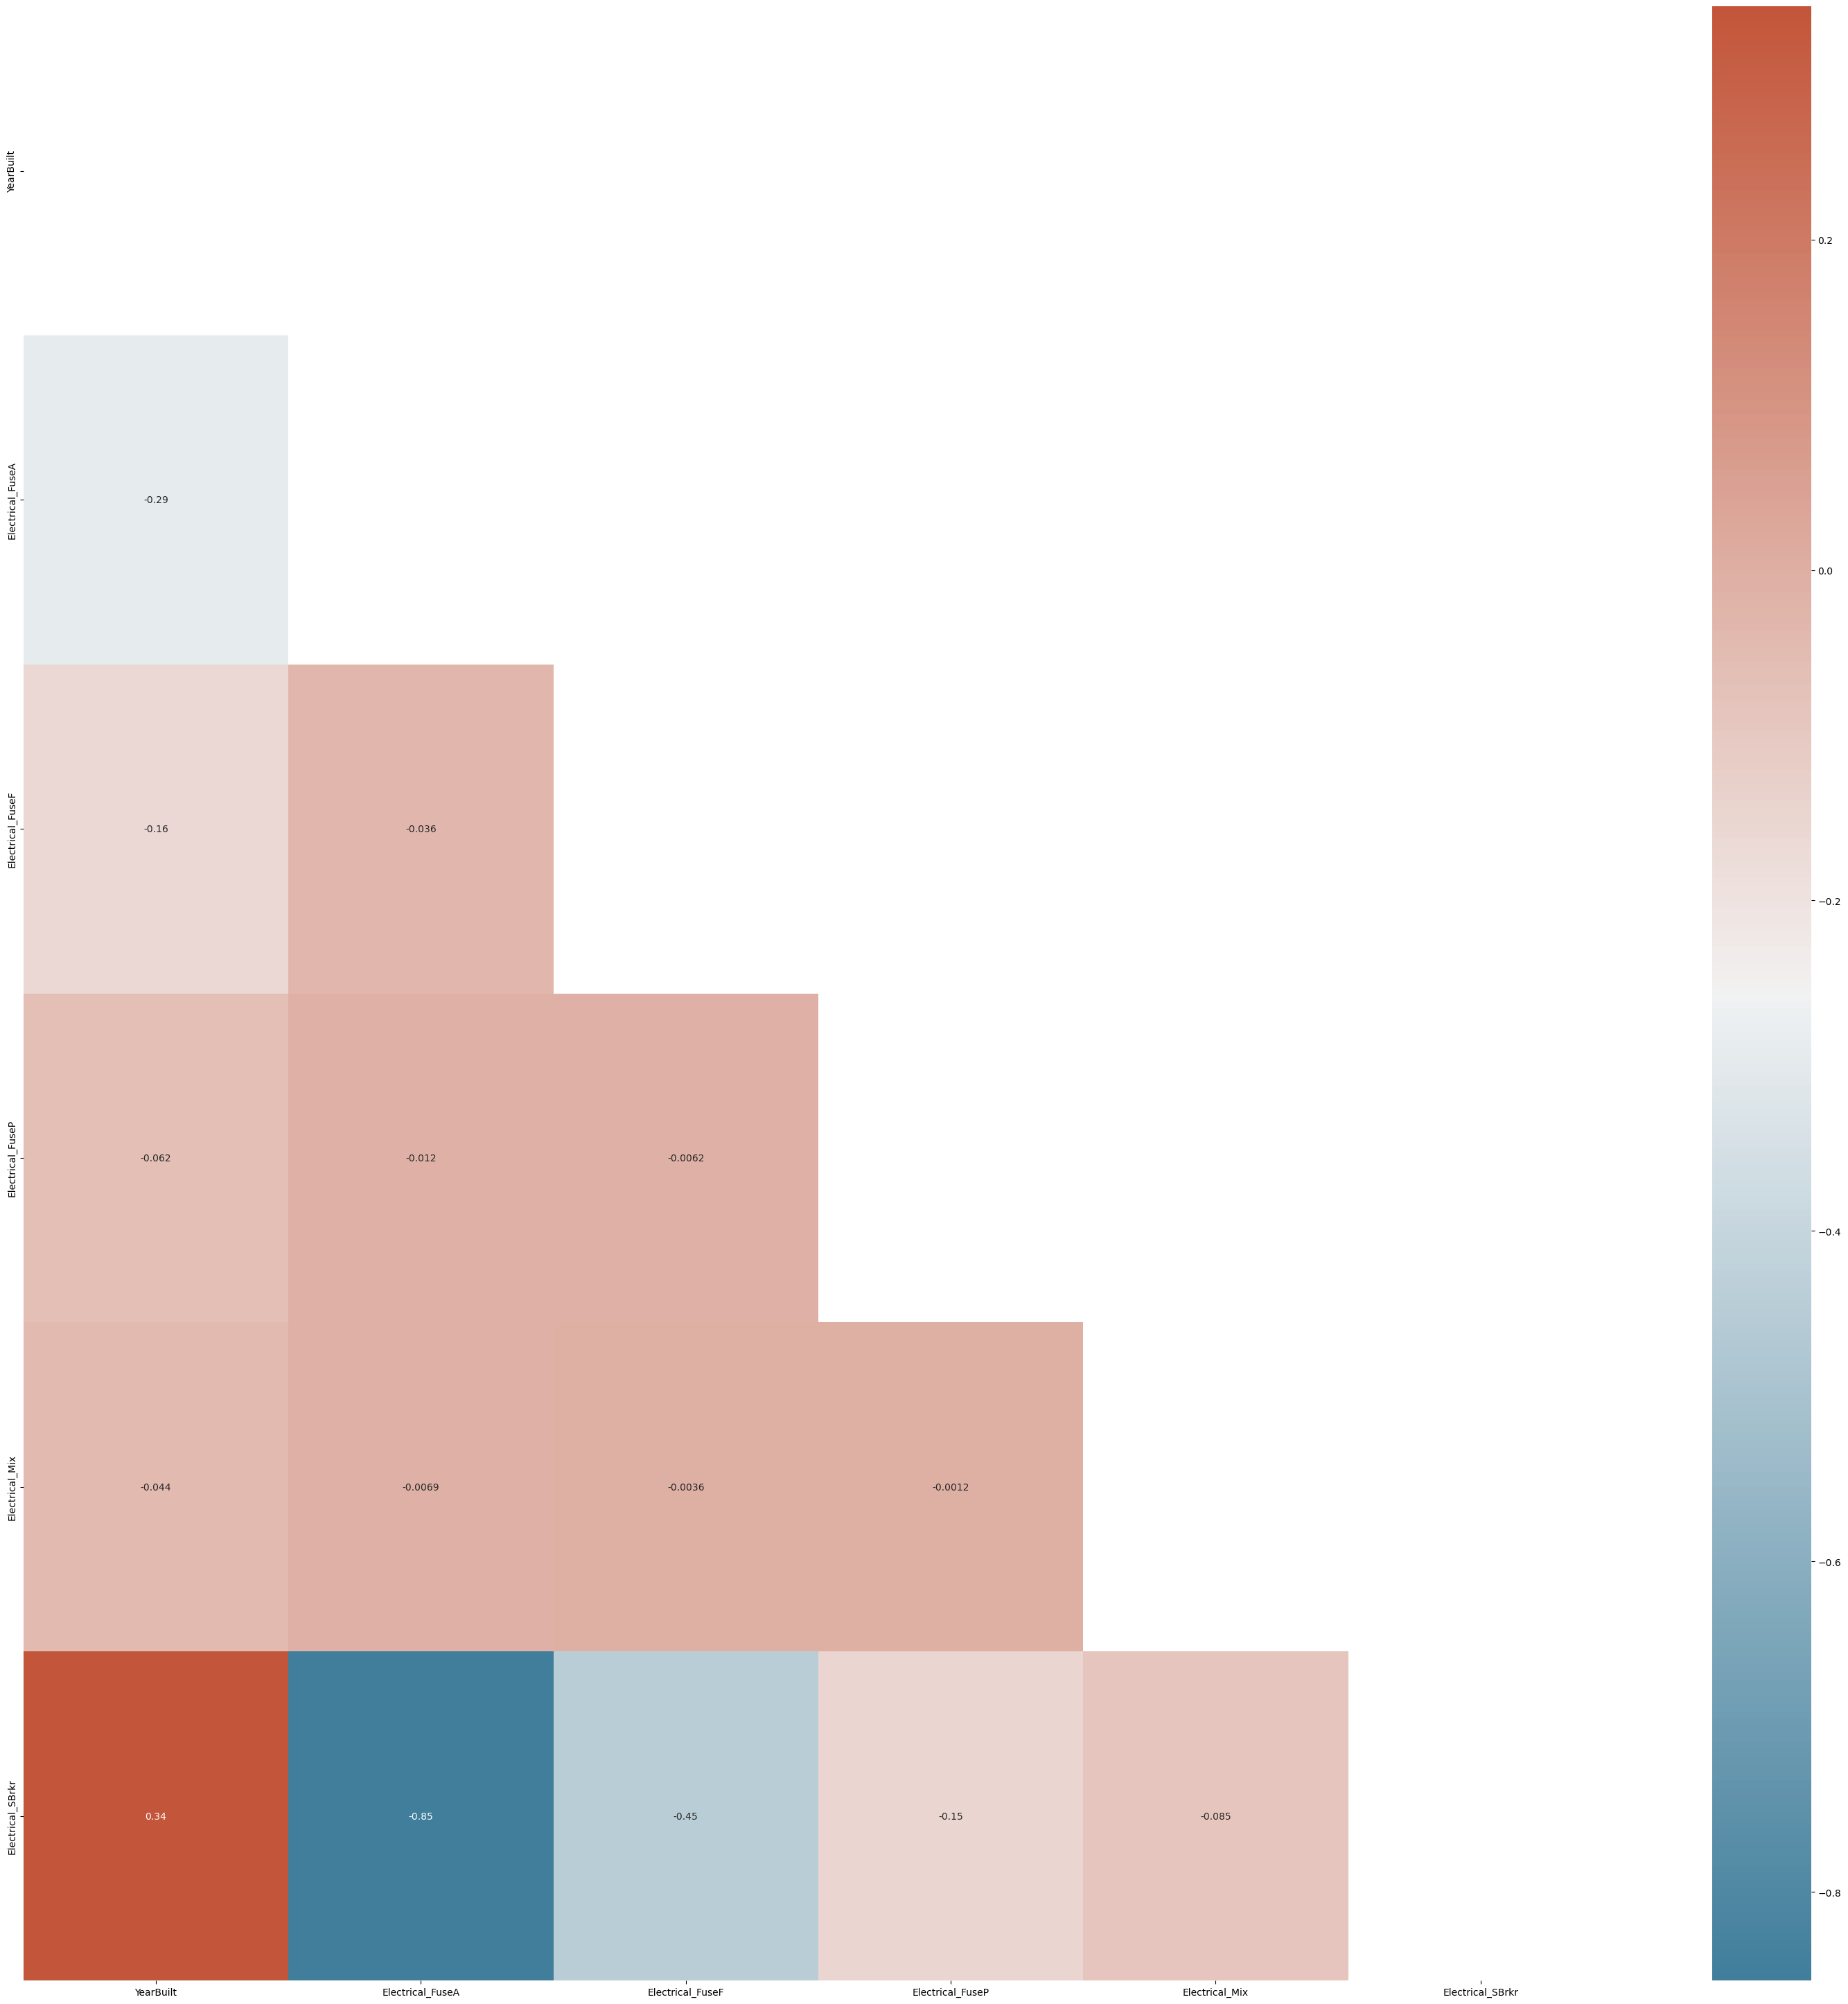

In [5]:
df_electrical_year = df.loc[:, ['YearBuilt', "Electrical"]]
with_dummies = pd.get_dummies(df_electrical_year, columns=['Electrical'])
get_corr(with_dummies)

There is a clear correlation between YearBuilt and the home having a circuit breaker. However, circuit breaker is by far the most common type of electrical system, with roughly 1330 samples, compared to the other 4 combined at 130 samples. There is still some logic to retaining all of these variables, since the electrical system being old may significantly lower sale price, due to increased costs to replace electrical equipment if/when it breaks or needs to be replaced in a remodel. 

# Investigate some other variables
With so many variables, its important to see which one's can potentially be discarded, at least at first. I'll check some information from a handful of variables and see if they are mostly identical entries, or if they seem relevant to home price

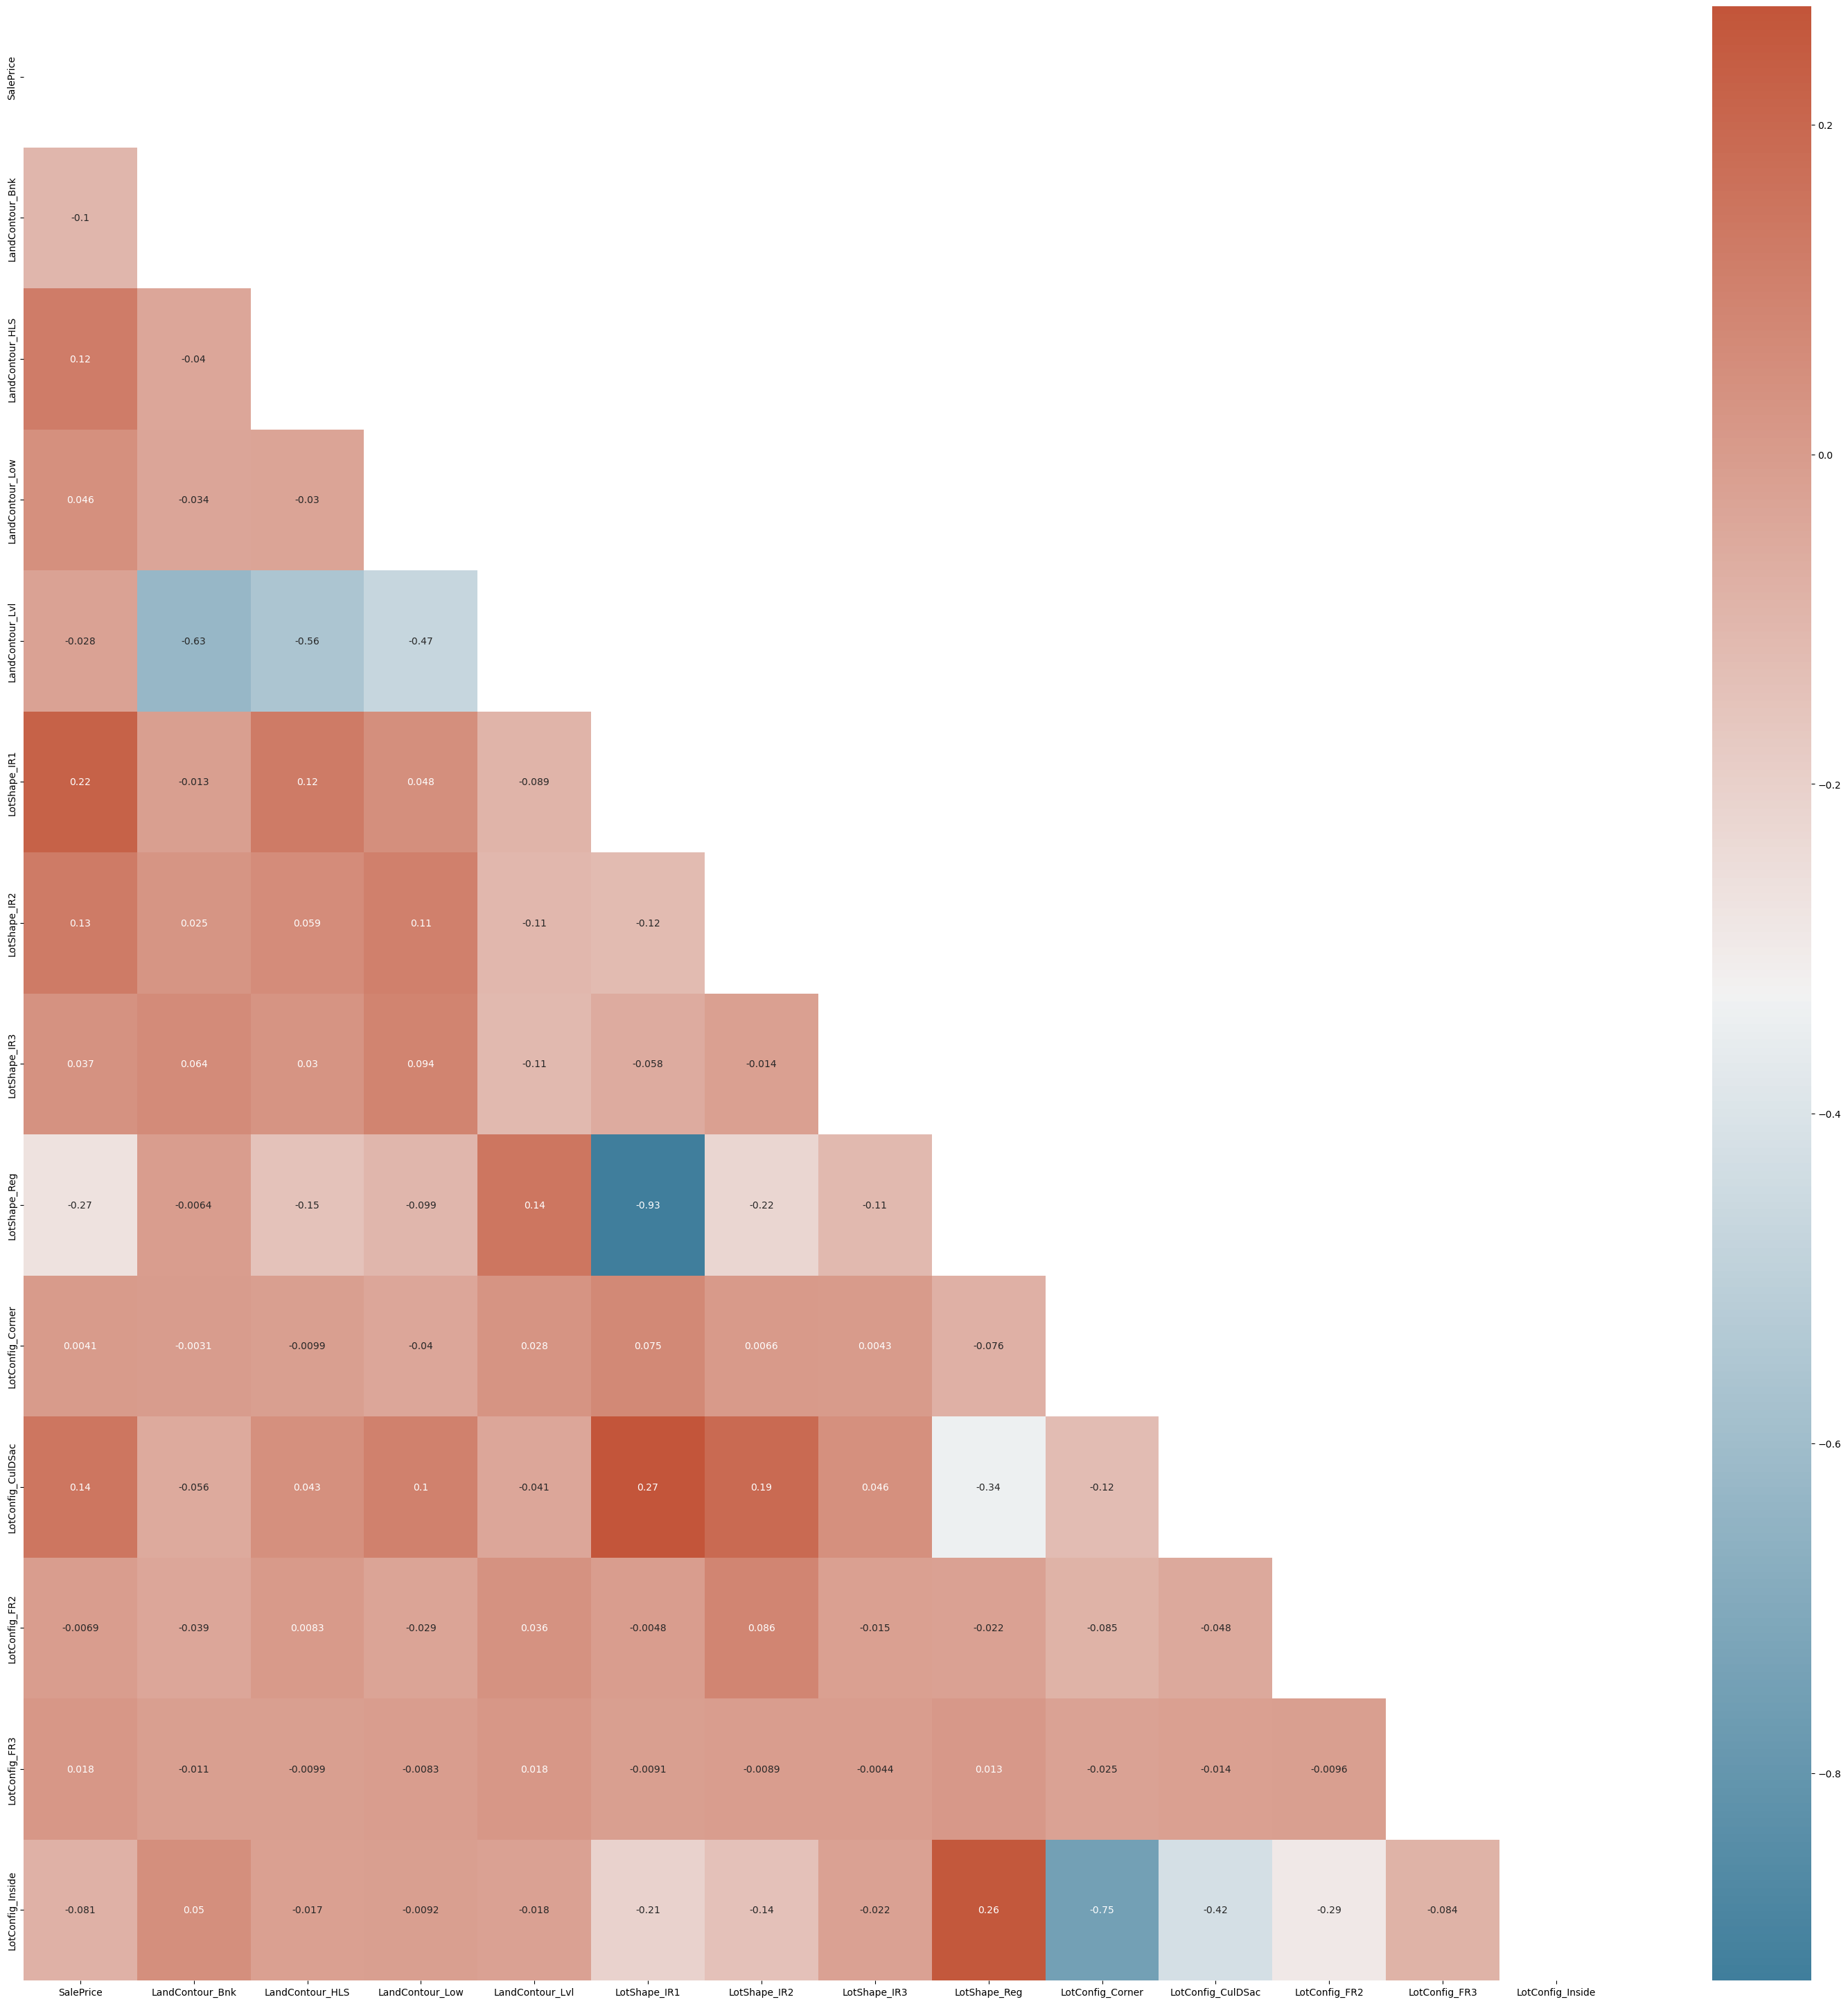

In [14]:
lot_features = df.loc[:, ['LandContour', 'LotShape', 'LotConfig', 'SalePrice']]
with_dummies = pd.get_dummies(lot_features)
get_corr(with_dummies)


Some lot features (shape, grade, etc.) do have correlation with sale price and weak correlation with each other, so maybe worth keeping.

In [23]:
df[df['Utilities'] == 'NoSeWa'].to_csv("../no_utils.csv")

All but 1 home had all utilities. That one home seems strange, given that it is in a culdesac. Since 1 entry won't be much help in deciding if utility access is relevant anyway, we can delete the index and then also delete 'Utilities' column.  